# **BRAIN SCAN CLASSIFICATION AND SEGMENTATION**



In this notebook, I will be creating 2 models. One that performs image classification on the MRI brain scan that will categorize them as having a tumor and not having a tumor. The second one is the image segmentation, which pinpoints where the tumor is located.

The Classification is done by using a Resnet Deep Learning Model. The Segmentation is done using a Resunet segmentation model.

## **Setting Up and Import Libraries**

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/'Healthcare AI Datasets'/Brain_MRI

/content/drive/MyDrive/Healthcare AI Datasets/Brain_MRI


In [6]:

import pandas as pd
import numpy as np
import seaborn as sns
import cv2
import tensorflow as tf
import os 
from skimage import io
from PIL import Image
from tensorflow.keras import backend as K
  
#Custom DataGenerator taken from kaggle:

class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = './', batch_size = 16, img_h = 256, img_w = 256, shuffle = True):

    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Get the number of batches per epoch'

    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):
    'Generate a batch of data'

    #generate index of batch_size length
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]

    #get the ImageId corresponding to the indexes created above based on batch size
    list_ids = [self.ids[i] for i in indexes]

    #get the MaskId corresponding to the indexes created above based on batch size
    list_mask = [self.mask[i] for i in indexes]


    #generate data for the X(features) and y(label)
    X, y = self.__data_generation(list_ids, list_mask)

    #returning the data
    return X, y

  def on_epoch_end(self):
    'Used for updating the indices after each epoch, once at the beginning as well as at the end of each epoch'
    
    #getting the array of indices based on the input dataframe
    self.indexes = np.arange(len(self.ids))

    #if shuffle is true, shuffle the indices
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):
    'generate the data corresponding the indexes in a given batch of images'

    # create empty arrays of shape (batch_size,height,width,depth) 
    #Depth is 3 for input and depth is taken as 1 for output becasue mask consist only of 1 channel.
    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

    #iterate through the dataframe rows, whose size is equal to the batch_size
    for i in range(len(list_ids)):
      #path of the image
      img_path = './' + str(list_ids[i])
      
      #mask path
      mask_path = './' + str(list_mask[i])
      
      #reading the original image and the corresponding mask image
      img = io.imread(img_path)
      mask = io.imread(mask_path)

      #resizing and coverting them to array of type float64
      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)
      
      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)

      #standardising 
      img -= img.mean()
      img /= img.std()
      
      mask -= mask.mean()
      mask /= mask.std()
      
      #Adding image to the empty array
      X[i,] = img
      
      #expanding the dimnesion of the image from (256,256) to (256,256,1)
      y[i,] = np.expand_dims(mask, axis = 2)
    
    #normalizing y
    y = (y > 0).astype(int)

    return X, y






def prediction(test, model, model_seg):
  """
  This function takes the test set, and first classifies each picture having a
  tumor or not and for the images that do, perform segmentation that predicts 
  where the tumor is located
  Inputs: test set DataFrame, classification model, segmentation model
  output: list, list, list
  """
  #directory
  directory = "./"

  #Creating empty list to store the results
  mask = []
  image_id = []
  has_mask = []

  #iterating through each image in the test data
  for i in test.image_path:

    path = directory + str(i)

    #reading the image
    img = io.imread(path)

    #Normalizing the image
    img = img * 1./255.

    #Reshaping the image
    img = cv2.resize(img,(256,256))

    #Converting the image into array
    img = np.array(img, dtype = np.float64)
    
    #reshaping the image from 256,256,3 to 1,256,256,3
    img = np.reshape(img, (1,256,256,3))

    #making prediction on the image
    is_defect = model.predict(img)

    #if tumour is not present we append the details of the image to the list
    
    if np.argmax(is_defect) == 0:
      image_id.append(i)
      has_mask.append(0)
      mask.append('No mask')
      continue

    #Read the image
    img = io.imread(path)

    #Creating a empty array of shape 1,256,256,1
    X = np.empty((1, 256, 256, 3))

    #resizing the image and coverting them to array of type float64
    img = cv2.resize(img,(256,256))
    img = np.array(img, dtype = np.float64)

    #standardising the image
    img -= img.mean()
    img /= img.std()

    #converting the shape of image from 256,256,3 to 1,256,256,3
    X[0,] = img

    #make prediction
    predict = model_seg.predict(X)
    
    #if the sum of predicted values is equal to 0 then there is no tumour
    if predict.round().astype(int).sum() == 0:
        image_id.append(i)
        has_mask.append(0)
        mask.append('No mask')
    else:
    #if the sum of pixel values are more than 0, then there is tumour
        image_id.append(i)
        has_mask.append(1)
        mask.append(predict)


  return image_id, mask, has_mask
        



In [53]:
# Custom loss functions taken from Towards Data Science
def tversky(y_true, y_pred, smooth = 1e-6):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true,tf.float32)
    y_pred = tf.cast(y_pred,tf.float32)
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def dice_coef(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true,tf.float32)
    y_pred = tf.cast(y_pred,tf.float32)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# **EDA**

In [7]:
# reads in image names dataframe
brain_df = pd.read_csv('data_mask.csv')

In [8]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [9]:
brain_df.head()

patient_id  ... mask
0  TCGA_CS_5395_19981004  ...    0
1  TCGA_CS_5395_19981004  ...    0
2  TCGA_CS_5395_19981004  ...    0
3  TCGA_CS_5395_19981004  ...    0
4  TCGA_CS_5395_19981004  ...    0

[5 rows x 4 columns]

In [10]:
brain_df.mask_path[1]

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'

In [11]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

In [13]:
# Creates bar plot showing number of instances for each class
import plotly.graph_objects as go
fig = go.Figure([go.Bar(x=brain_df['mask'].value_counts().index,y=brain_df['mask'].value_counts())])
fig.update_traces(marker_color='rgb(0,200,0)',marker_line_color='rgb(255,0,0)',marker_line_width=3,opacity=.6)
fig.show()

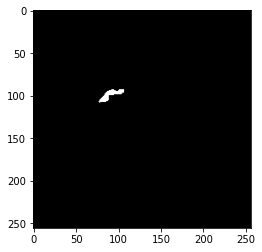

In [14]:
plt.imshow(cv2.imread(brain_df.mask_path[623]))

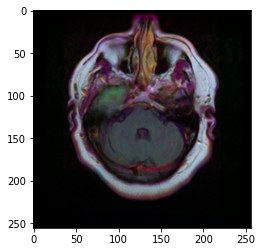

In [15]:
plt.imshow(cv2.imread(brain_df.image_path[623]))

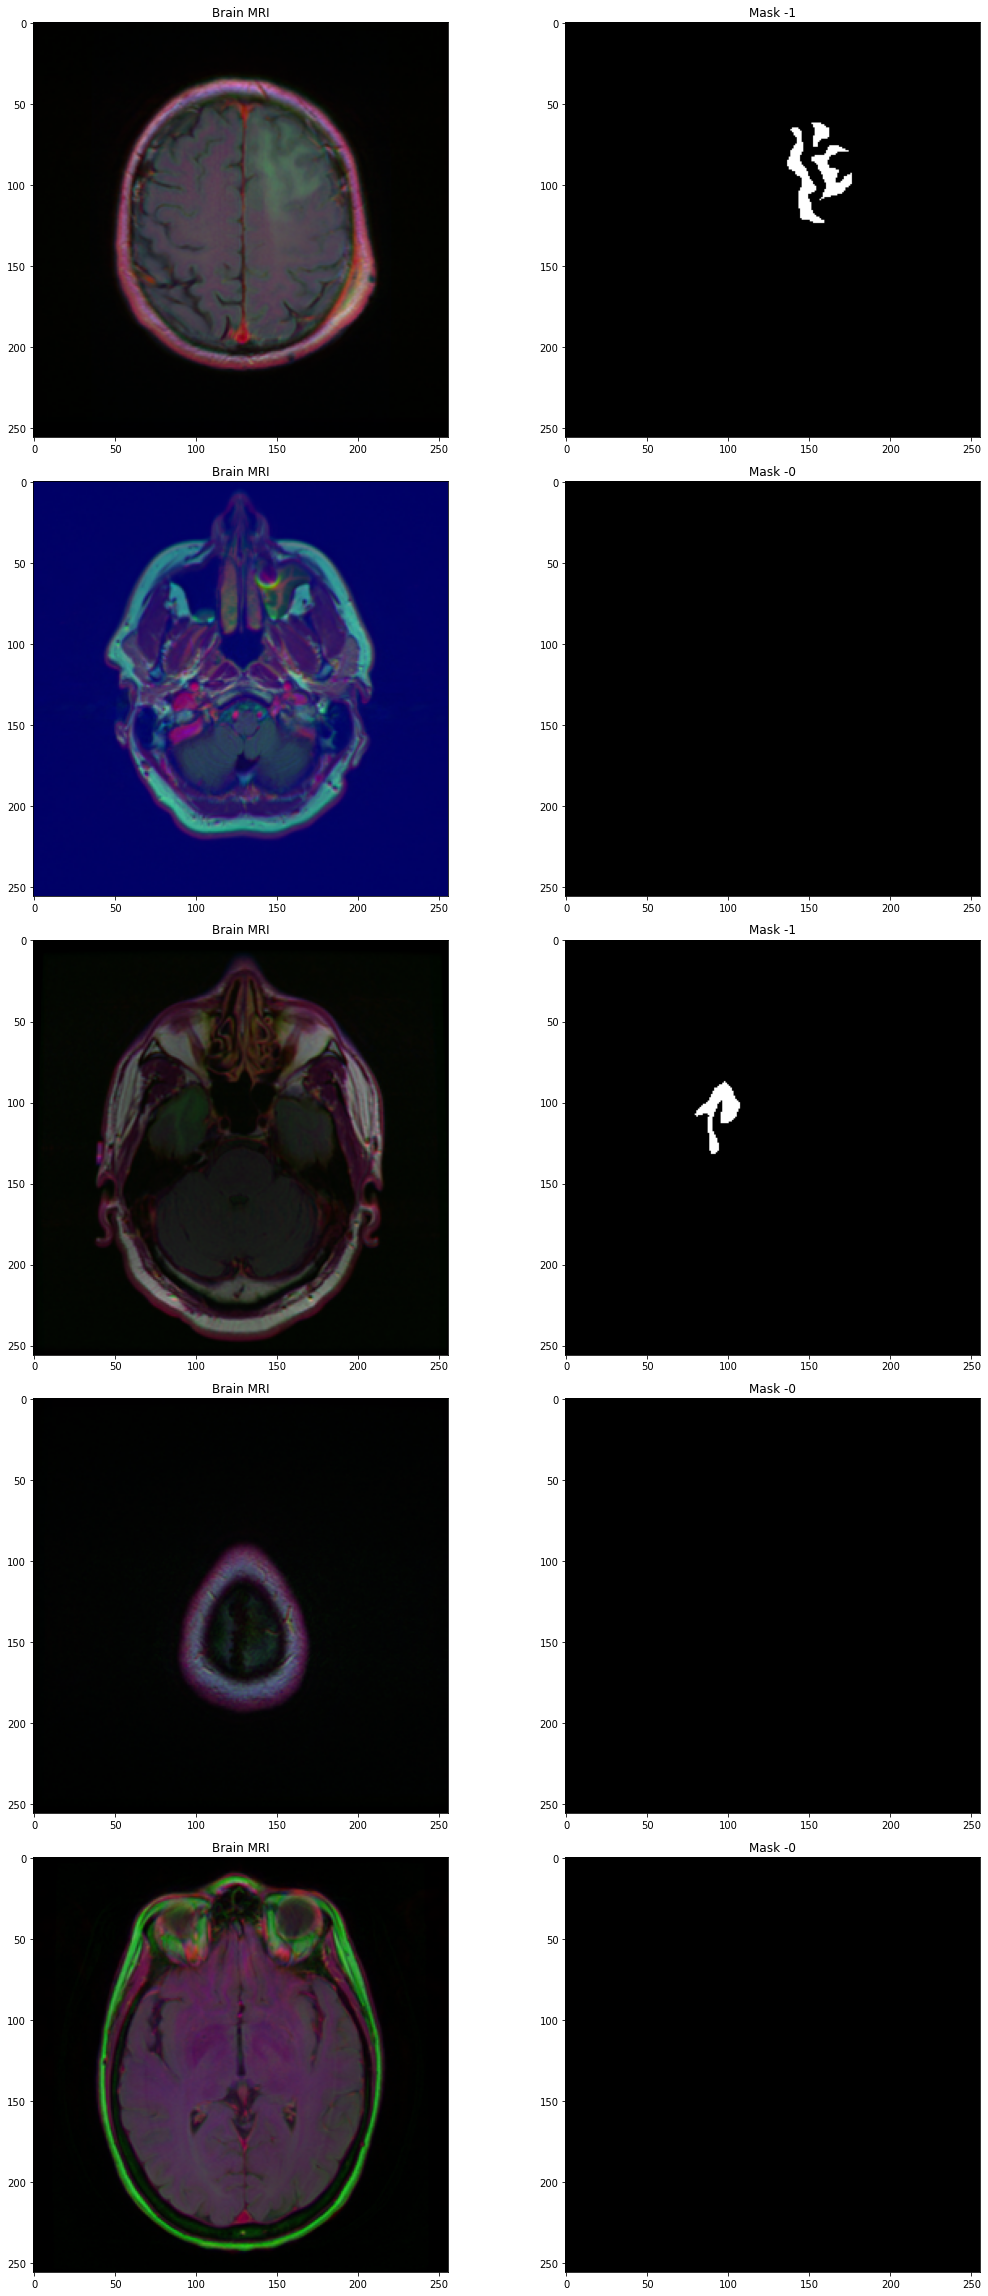

In [17]:
# Randomly selects 5 images and its corresponding masks to display
import random
fig, axs = plt.subplots(5,2,figsize=(16,32))
count = 0
for x in range(5):
  i = random.randint(0,len(brain_df))
  axs[count][0].title.set_text("Brain MRI")
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i]))
  axs[count][1].title.set_text("Mask -" + str(brain_df['mask'][i]))
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i]))
  count += 1
fig.tight_layout()

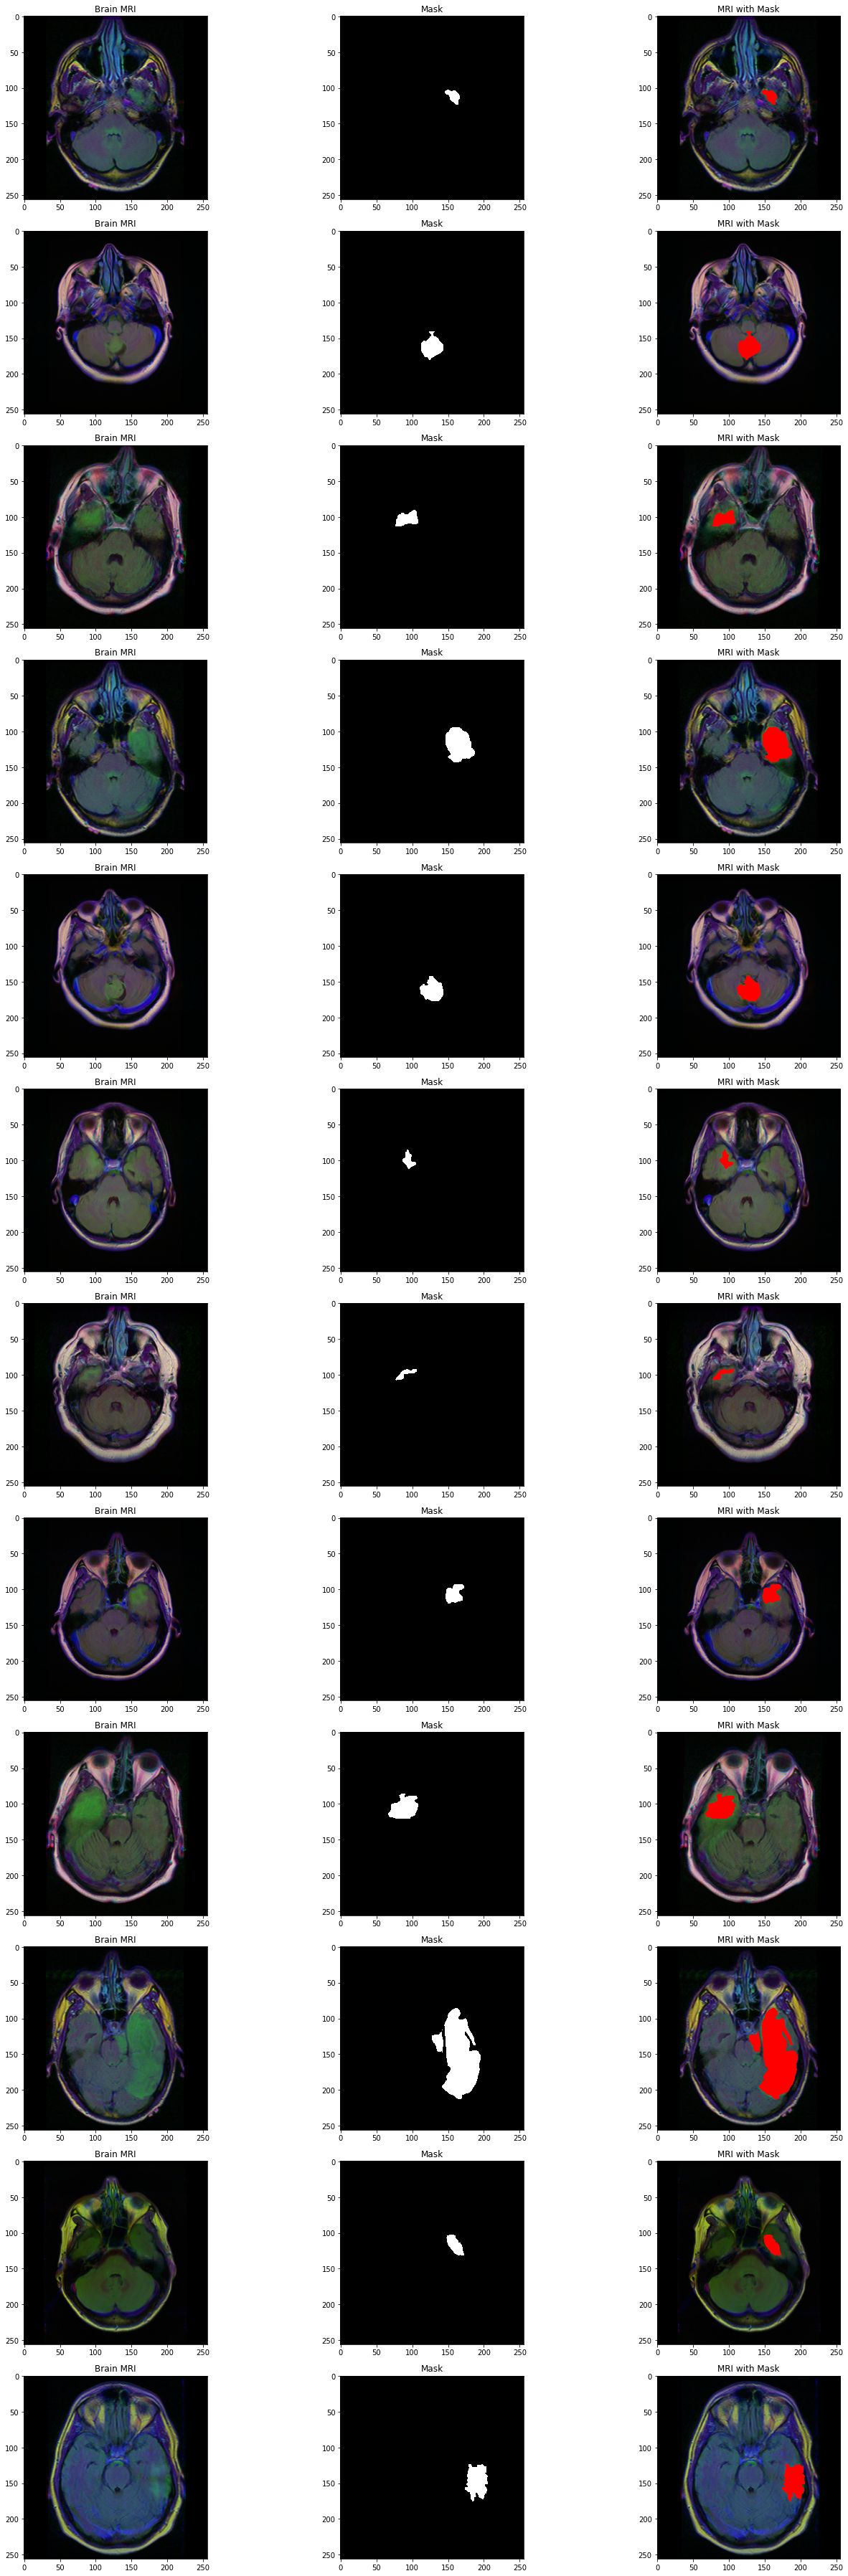

In [18]:
# Creates overlay on MRI picture
count = 0
fig, axs = plt.subplots(12, 3, figsize=(20,50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] == 1 and count < 12:
    img = io.imread(brain_df.image_path[i])
    axs[count][0].title.set_text('Brain MRI')
    axs[count][0].imshow(img)

    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text('Mask')
    axs[count][1].imshow(mask,cmap='gray')

    img[mask==255] = (255,0,0)
    axs[count][2].title.set_text('MRI with Mask')
    axs[count][2].imshow(img)
    count+=1
fig.tight_layout()


In [19]:
brain_df_train = brain_df.drop(columns=['patient_id'])
brain_df_train.shape

(3929, 3)

In [20]:
# Convert to string
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x:str(x))

In [21]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


### **Classification Model**

In [22]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(brain_df_train,test_size=.15)

In [23]:
from keras_preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255.,validation_split=.15)

In [26]:
# Create a data generator for train images
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [27]:
basemodel = ResNet50(weights='imagenet',include_top=False,input_tensor=Input(shape=(256,256,3)))

94773248/94765736 [==============================] - 0s 0us/step


In [28]:
#basemodel.summary()

In [29]:
for layer in basemodel.layers:
  layers.trainable = False

In [30]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(3,3))(headmodel)
headmodel = Flatten(name='flatten')(headmodel)
headmodel = Dense(256,activation="relu")(headmodel)
headmodel = Dropout(.3)(headmodel)
headmodel = Dense(256,activation="relu")(headmodel)
headmodel = Dropout(.3)(headmodel)
headmodel = Dense(128,activation="relu")(headmodel)
headmodel = Dropout(.1)(headmodel)
headmodel = Dense(16,activation="relu")(headmodel)
headmodel = Dropout(.1)(headmodel)
headmodel = Dense(2,activation='softmax')(headmodel)

model = Model(inputs=basemodel.input,outputs=headmodel)

In [31]:

#model.summary()

In [32]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [33]:
earlystopping = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=20)
checkpointer = ModelCheckpoint(filepath='classifier-resnet-weights.hdf5',verbose=1,save_best_only=True)

In [34]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 10, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

Epoch 1/10
177/177 [==============================] - 893s 5s/step - loss: 0.6776 - accuracy: 0.7366 - val_loss: 5.6277 - val_accuracy: 0.6431

Epoch 00001: val_loss improved from inf to 5.62771, saving model to classifier-resnet-weights.hdf5
Epoch 2/10
177/177 [==============================] - 39s 221ms/step - loss: 0.5020 - accuracy: 0.8244 - val_loss: 1.1208 - val_accuracy: 0.6411

Epoch 00002: val_loss improved from 5.62771 to 1.12081, saving model to classifier-resnet-weights.hdf5
Epoch 3/10
177/177 [==============================] - 40s 225ms/step - loss: 0.3257 - accuracy: 0.8514 - val_loss: 0.7485 - val_accuracy: 0.5726

Epoch 00003: val_loss improved from 1.12081 to 0.74848, saving model to classifier-resnet-weights.hdf5
Epoch 4/10
177/177 [==============================] - 40s 227ms/step - loss: 0.4658 - accuracy: 0.8260 - val_loss: 0.6635 - val_accuracy: 0.6512

Epoch 00004: val_loss improved from 0.74848 to 0.66348, saving model to classifier-resnet-weights.hdf5
Epoch 5/10

In [35]:
# Write model to json
# model_json = model.to_json()
# with open("classifier-resnet-model.json","w") as json_file:
#   json_file.write(model_json)

In [116]:
print(tf.__version__)

2.4.1


In [29]:
# Best Model and weights comboniation
with open('resnet-50-MRI.json','r') as json_file:
  json_savedModel = json_file.read()
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights.hdf5')
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
#model.summary()

In [36]:
test_predict = model.predict(test_generator,steps=test_generator.n//16, verbose=1)

36/36 [==============================] - 152s 4s/step


In [37]:
test_predict

array([[9.9991059e-01, 8.9450361e-05],
       [1.3611912e-03, 9.9863881e-01],
       [9.9595118e-01, 4.0487731e-03],
       ...,
       [1.3955575e-01, 8.6044425e-01],
       [1.7689915e-01, 8.2310081e-01],
       [9.9999905e-01, 9.3793221e-07]], dtype=float32)

In [38]:
predict = []
for i in test_predict:
  predict.append(str(np.argmax(i)))
predict = np.asarray(predict)

In [39]:
predict

array(['0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '1', '1', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0',
       '0', '0', '0', '1', '1', '0', '0', '0', '1', '0', '0', '0', '0',
       '1', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0',
       '0', '1', '0', '0', '1', '0', '0', '1', '0', '1', '0', '0', '1',
       '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0',
       '0', '1', '0', '1', '0', '0', '0', '0', '0', '1', '1', '0', '0',
       '0', '0', '0', '1', '1', '0', '1', '1', '0', '1', '0', '0', '0',
       '0', '0', '1', '0', '0', '1', '0', '0', '1', '0', '0', '0', '1',
       '0', '1', '0', '0', '0', '1', '1', '0', '0', '1', '0', '0', '0',
       '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '1', '1',
       '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '1', '0', '0',
       '1', '0', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0

In [40]:
original = np.asarray(test['mask'])[:len(predict)]
len(original)

576

## **Evaluating Classification Model**

In [41]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(original,predict)
accuracy

0.8923611111111112

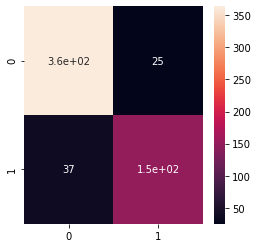

In [42]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(original,predict)
plt.figure(figsize=(4,4))
sns.heatmap(cm,annot=True)

In [43]:
from sklearn.metrics import classification_report
print(classification_report(original,predict))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       389
           1       0.86      0.80      0.83       187

    accuracy                           0.89       576
   macro avg       0.88      0.87      0.88       576
weighted avg       0.89      0.89      0.89       576



In [44]:
brain_df_mask = brain_df[brain_df['mask']==1]
brain_df_mask.shape

(1373, 4)

In [45]:
X_train,X_val =train_test_split(brain_df_mask,test_size=.15)
X_test, X_val = train_test_split(X_val,test_size=.5)

In [46]:
train_ids=list(X_train.image_path)
train_mask = list(X_train.mask_path)
val_ids = list(X_val.image_path)
val_mask = list(X_val.mask_path)

In [47]:
# X_train['mask'] = X_train['mask'].apply(lambda x:str(x))
# X_val['mask'] = X_val['mask'].apply(lambda x: str(x))

## **Segmentation Model**

In [48]:
# Resblock architecture
def resblock(X,f):
  X_copy = X
  X = Conv2D(f,kernel_size=(1,1),strides=(1,1),kernel_initializer='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  X = Conv2D(f,kernel_size=(3,3),strides=(1,1),padding='same',kernel_initializer='he_normal')(X)
  X = BatchNormalization()(X)
  X_copy = Conv2D(f,kernel_size=(1,1),strides=(1,1),kernel_initializer='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)
  X = Add()([X,X_copy])
  X = Activation('relu')(X)
  return X

In [49]:
def upsample_concat(x,skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x,skip])
  return merge

In [50]:
# ResUNet Architecture
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )

In [51]:

train_generator = DataGenerator(train_ids,train_mask,'./',img_h=256, img_w=256)
test_generator = DataGenerator(val_ids,val_mask,'./',img_h=256, img_w=256)

In [54]:
adam = tf.keras.optimizers.Adam(lr = 0.005, epsilon = 0.1)
#model_seg.compile(optimizer = 'adam', loss = dice_coef_loss, metrics = [dice_coef])
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [55]:
# Write segmentation model to json
# model_json = model_seg.to_json()
# with open("segmentation-resunet-model.json","w") as json_file:
#   json_file.write(model_json)

In [56]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-weights.hdf5", verbose=1, save_best_only=True)

In [57]:

history = model_seg.fit(train_generator, epochs = 1, validation_data = test_generator, callbacks = [checkpointer, earlystopping])

72/72 [==============================] - 341s 5s/step - loss: 0.9294 - tversky: 0.0930 - val_loss: 0.9409 - val_tversky: 0.0780

Epoch 00001: val_loss improved from inf to 0.94087, saving model to ResUNet-weights.hdf5


In [102]:
# Best Segmentation model
# with open('ResUNet-MRI.json', 'r') as json_file:
#     json_savedModel= json_file.read()

# # load the model architecture 
# model_seg = tf.keras.models.model_from_json(json_savedModel)
# model_seg.load_weights('weights_seg.hdf5')
# adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
# model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [103]:
#model_seg.summary()

In [58]:
image_id, mask, has_mask = prediction(test, model, model_seg)

In [111]:
test

image_path  ... mask
1604  TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_15...  ...    1
842   TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_8.tif  ...    0
2551  TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_24...  ...    1
3833  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_61...  ...    0
2599  TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_25...  ...    0
...                                                 ...  ...  ...
3508  TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_43...  ...    0
446   TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_5.tif  ...    0
983   TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_9.tif  ...    0
1808  TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_17...  ...    0
2471  TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_23...  ...    1

[590 rows x 3 columns]

In [105]:
# creating a dataframe for the result
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

image_path  ... has_mask
0    TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_15...  ...        1
1    TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_8.tif  ...        0
2    TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_24...  ...        1
3    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_61...  ...        0
4    TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_25...  ...        0
..                                                 ...  ...      ...
585  TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_43...  ...        0
586  TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_5.tif  ...        0
587  TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_9.tif  ...        0
588  TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_17...  ...        0
589  TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_23...  ...        1

[590 rows x 3 columns]

In [106]:
df_pred[df_pred['has_mask']==1]

image_path  ... has_mask
0    TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_15...  ...        1
2    TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_24...  ...        1
8    TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_36...  ...        1
9    TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_22...  ...        1
10   TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_20...  ...        1
..                                                 ...  ...      ...
579  TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_12...  ...        1
580  TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_28...  ...        1
581  TCGA_HT_7877_19980917/TCGA_HT_7877_19980917_27...  ...        1
584  TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_9.tif  ...        1
589  TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_23...  ...        1

[193 rows x 3 columns]

In [107]:
df_pred = test.merge(df_pred, on = 'image_path')

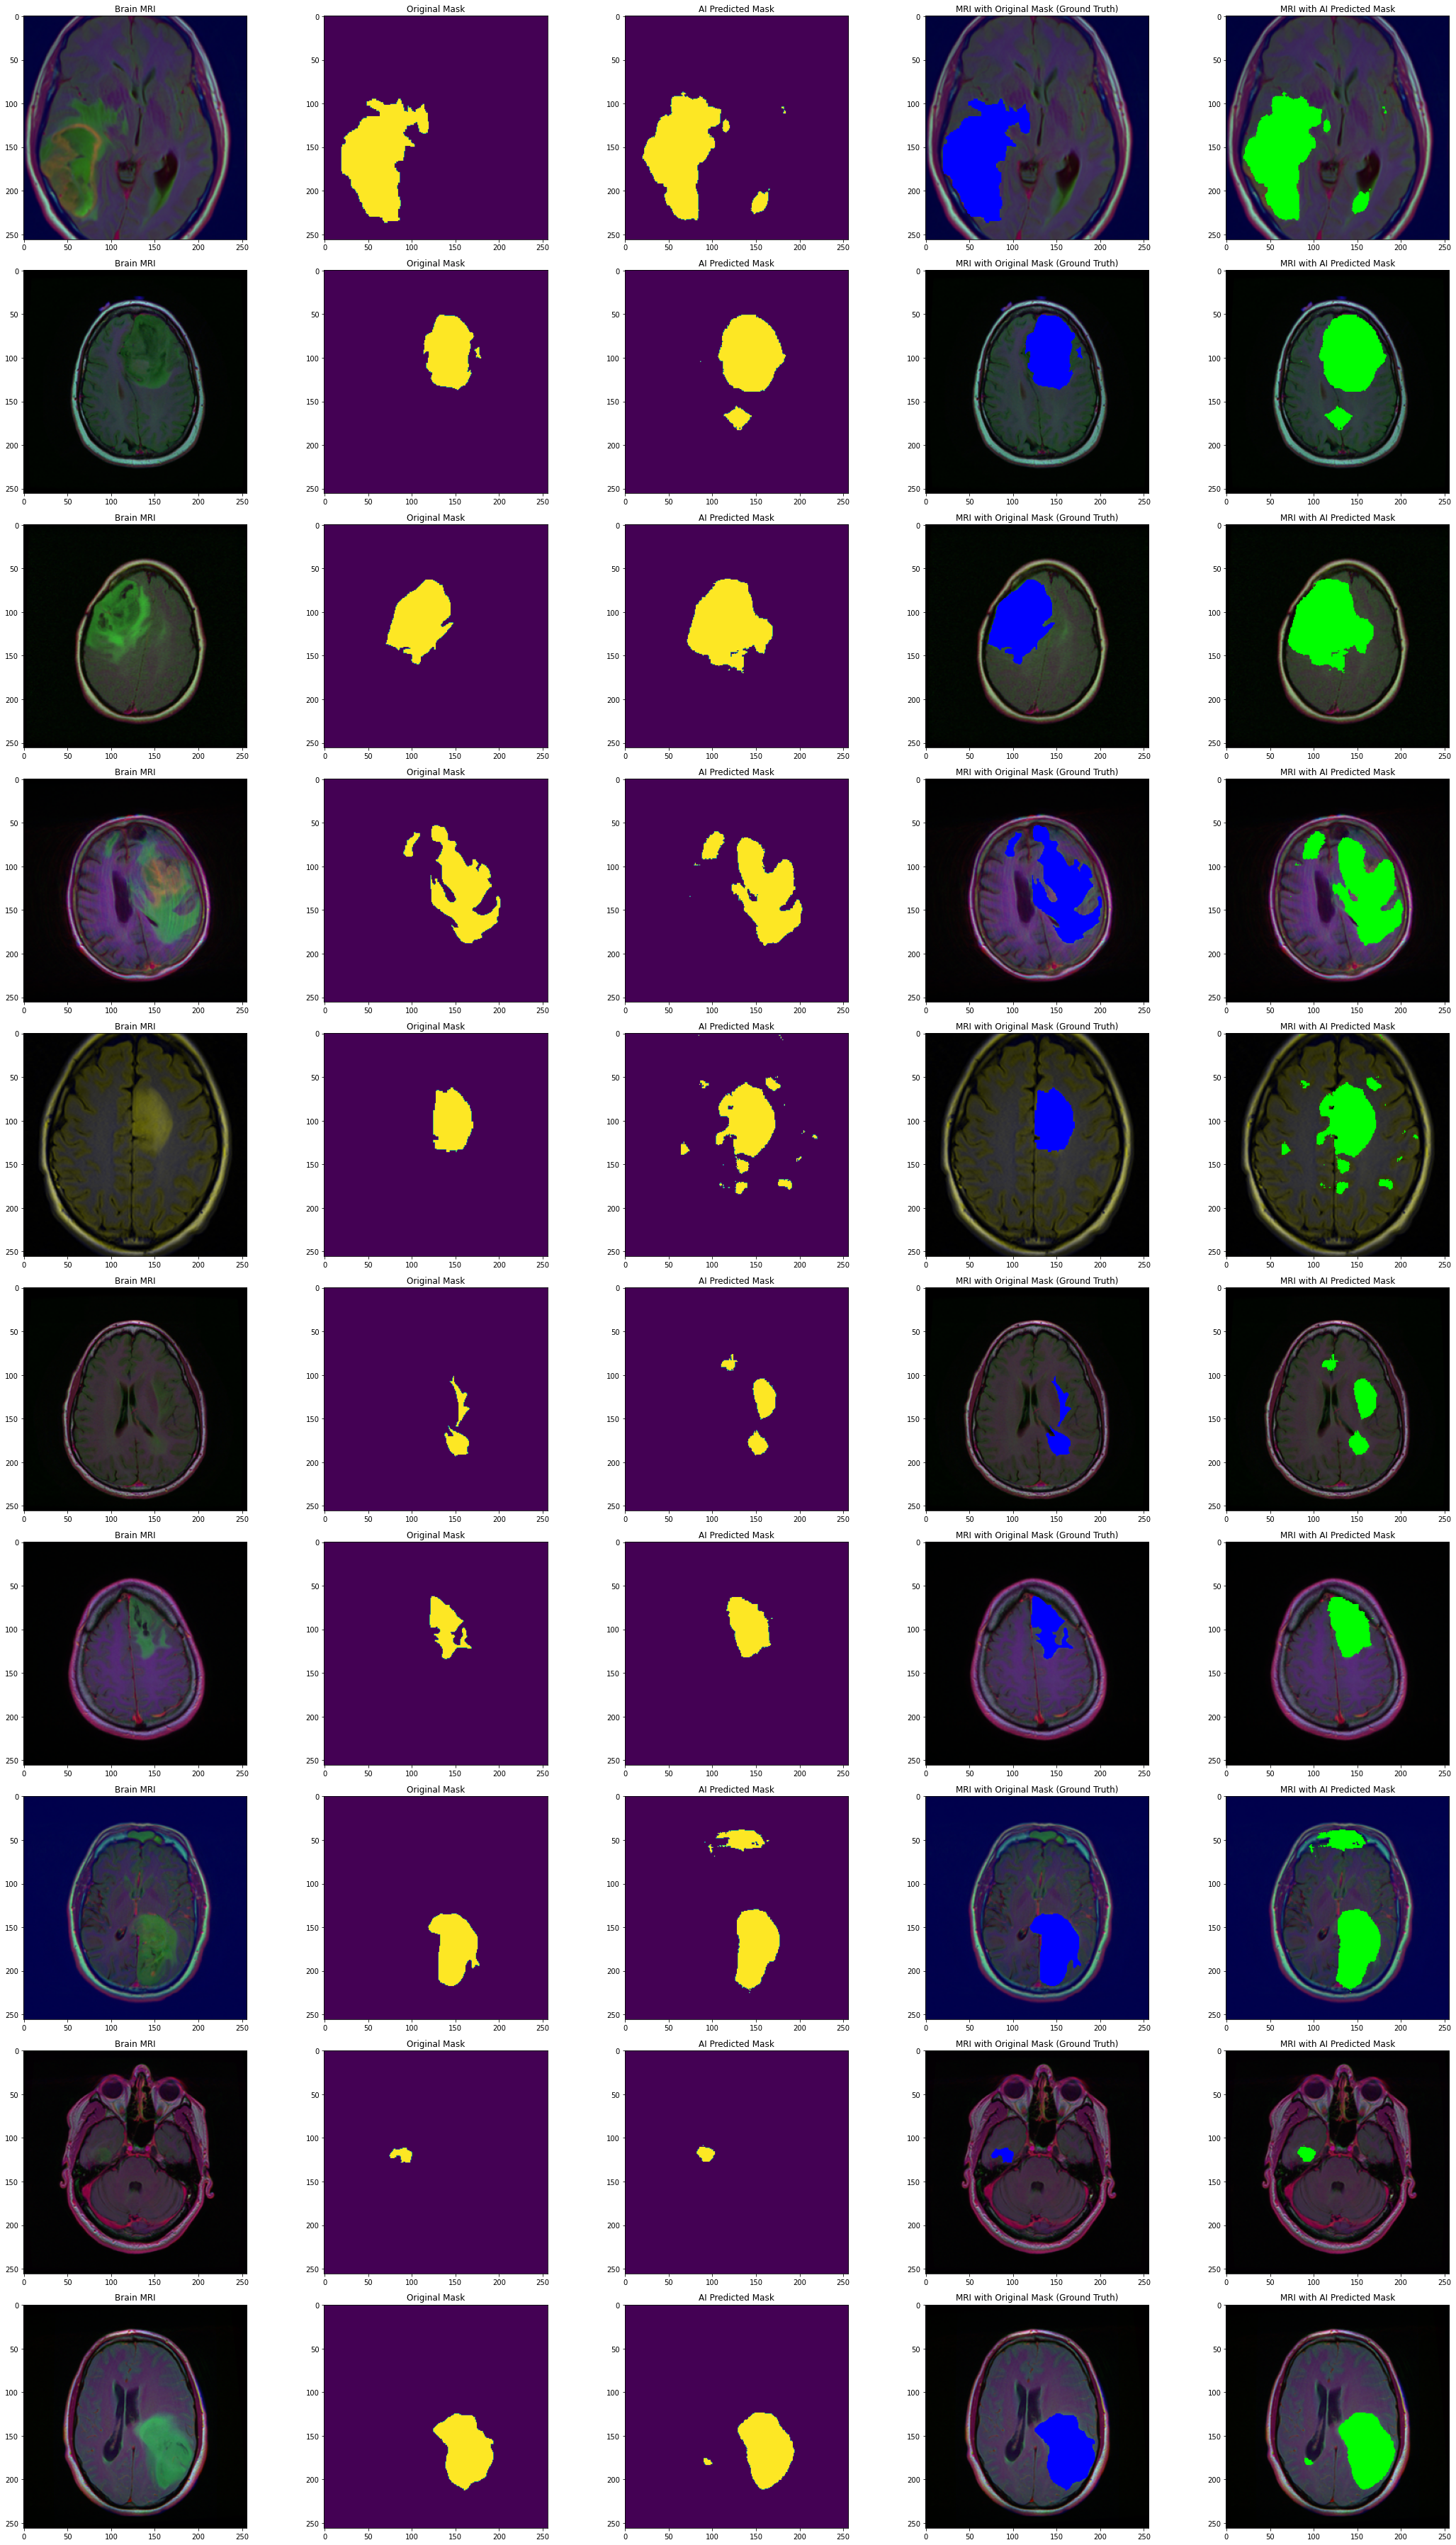

In [108]:
count = 0 
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image 
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image 
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)
    
    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (0, 0, 255)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()

In [109]:
model_json = model_seg.to_json()
with open("segmentation-resunet-model.json","w") as json_file:
  json_file.write(model_json)

## **Resources**

In [1]:
# https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation
# https://www.kaggle.com/ekhtiar/resunet-a-baseline-on-tensorflow
# https://setosa.io/ev/image-kernels/
# https://arxiv.org/pdf/1512.03385.pdf
# https://www.udemy.com/course/modern-artificial-intelligence-applications/
#https://towardsdatascience.com/dealing-with-class-imbalanced-image-datasets-1cbd17de76b5